In [3]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

import os
from mpl_toolkits.basemap import Basemap

In [11]:
Basemap()

In [4]:
with open('models/model_up.p', 'rb') as file:
    model_up = pickle.load(file)
with open('locations.p', 'rb') as file:
    locations = pickle.load(file)
with open('models/vec.p', 'rb') as file:
    vec = pickle.load(file)
with open('data/predictor.p', 'rb') as file:
    pred = pickle.load(file)
with open('data/text.p', 'rb') as file:
    text = pickle.load(file)

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when

In [5]:
with open('data/target.p', 'rb') as file:
    target = pickle.load(file)

In [6]:
pred['location'] = pred['address'].apply(lambda x: locations[x])

In [7]:
train_mask = (pred['status_date'] - pd.to_datetime('2003-01-01')).apply(lambda x: x.days) <= 5478

In [8]:
train_mask = train_mask.values

In [9]:
pred['has_existing_stories'] = (~pred['existing_stories'].isnull()).astype(int)
pred['existing_stories'] = pred['existing_stories'].fillna(0)

In [10]:
X_text = vec.transform(text)

In [11]:
y = (target['fire_rate_after'] > target['fire_rate_before']).astype(int)

In [12]:
x_axis, y_axis = np.array([x for x,y in pred.location]), np.array([y for x,y in pred.location])

In [13]:
sample_idx = np.random.choice(423099, 1000)

In [14]:
pred['prediction'] = model_up.predict_proba?

In [ ]:
pred['prediction'] = model_up.predict_proba

In [15]:
pred['prediction'] = model_up.predict_proba(pred, X_text)

In [16]:
mask = (pred['status_date'].apply(lambda x: x.year) > 2017).values

In [17]:
pred['prediction'].iloc[sample_idx].shape

(1000,)

In [18]:
sample_idx = np.random.choice(mask.sum(), 1000)

In [19]:
def coloring(number):
    if number > .35:
        return 'r'
    elif number > .2:
        return 'orange'
    else:
        return 'g'
f = np.vectorize(coloring)

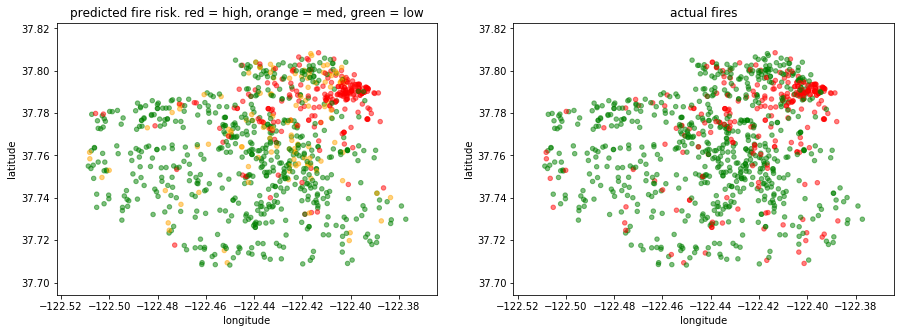

In [31]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].set_title('predicted fire risk. red = high, orange = med, green = low')
axs[0].set_xlabel('longitude')
axs[0].set_ylabel('latitude')
axs[0].scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(pred['prediction'][mask].iloc[sample_idx]), alpha = .5, s = 20)

axs[1].set_title('actual fires')
axs[1].set_xlabel('longitude')
axs[1].set_ylabel('latitude')
axs[1].scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(y[mask].iloc[sample_idx]), alpha = .5, s = 20)

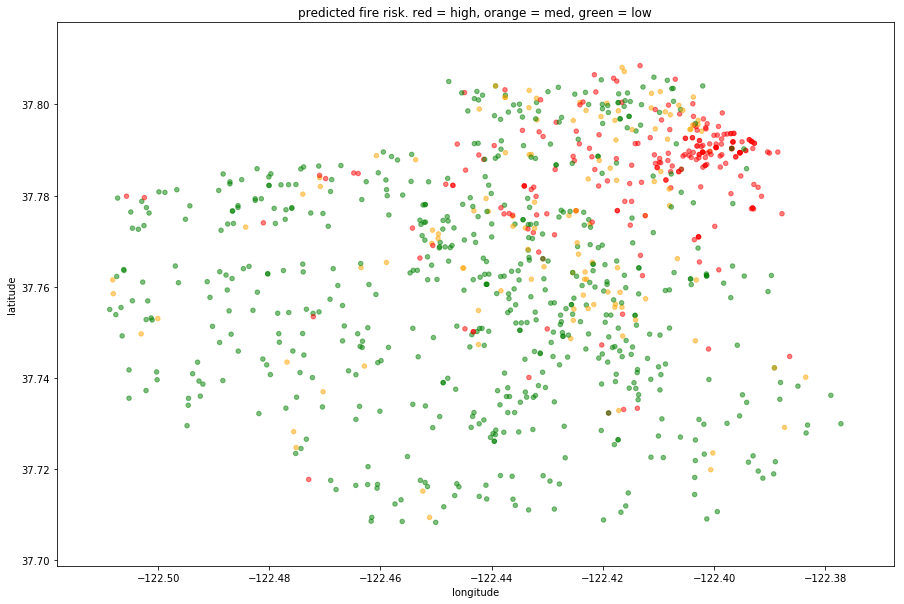

In [25]:
plt.figure(figsize = (15,10))
plt.title('predicted fire risk. red = high, orange = med, green = low')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(pred['prediction'][mask].iloc[sample_idx]), alpha = .5, s = 20)

In [33]:
model_up.threshold

0.358

In [85]:
np.vectorize(lambda x: bool(x))(x_axis)

array([ True,  True,  True, ...,  True,  True,  True])

In [91]:
ll_lon = (x_axis[np.vectorize(lambda x: bool(x))(x_axis)]).min()
ll_lat = (y_axis[np.vectorize(lambda x: bool(x))(x_axis)]).min()
ur_lon = (x_axis[np.vectorize(lambda x: bool(x))(x_axis)]).max()
ur_lat = (y_axis[np.vectorize(lambda x: bool(x))(x_axis)]).max()

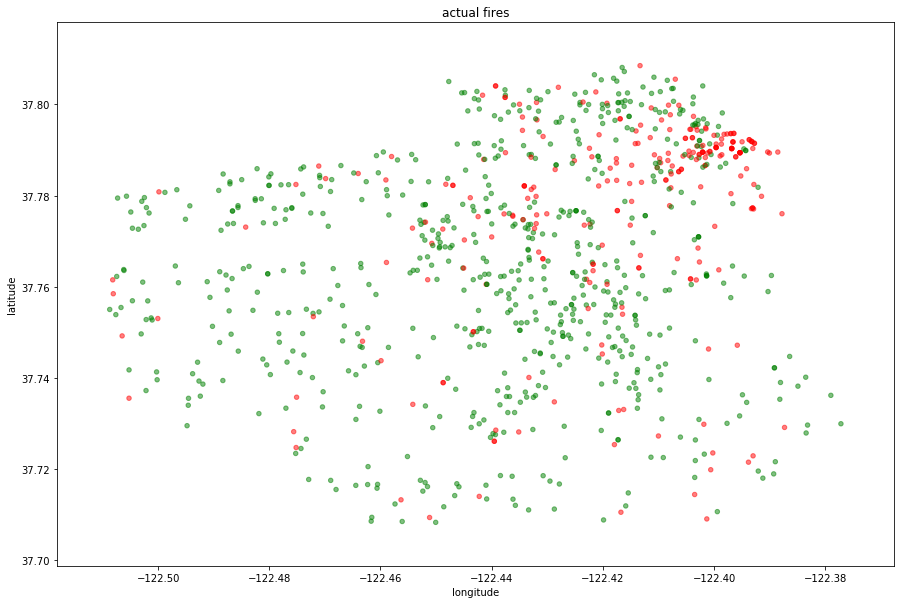

In [23]:
#m = Basemap(llcrnrlon = ll_lon, llcrnrlat = ll_lat, urcrnrlon = ur_lon, urcrnrlat = ur_lat, resolution = 'i')
#m.drawcoastlines()
plt.figure(figsize = (15,10))
plt.title('actual fires')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(x_axis[mask][sample_idx], y_axis[mask][sample_idx], c = f(y[mask].iloc[sample_idx]), alpha = .5, s = 20)

In [158]:
model_up.threshold

0.358

In [44]:
roc_auc_score(y[mask], pred['prediction'][mask])

0.8429429964788637

In [49]:
accuracy_score(y[mask], (pred['prediction'][mask]>.358).astype(int))

0.8041355061948878

In [46]:
1 - y[mask].mean()

0.7200301372921085

In [52]:
map = Basemap()

In [108]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [113]:
DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"
import os
import tarfile
from six.moves import urllib

HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [114]:
import pandas as pd
coords = pd.concat([housing['latitude'], housing['longitude'], housing['population']], axis=1)
coords = coords.sample(frac=0.1, replace=True)
cases = []
colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']
months = {6:'June',7:'July',8:'Aug',9:'Sept'}

for i in range(6,10)[::-1]:
    cases.append(go.Scattergeo(
        lon = coords['longitude'],
        lat = coords['latitude'],
        marker = dict(
            size = coords['population']/1000,
            color = 'colors[i-6]',
            opacity = .4,
            line = dict(width = 0)
        ),
    ) )

cases[0]['mode'] = 'markers'

layout = go.Layout(
    title = 'Hey look! It\'s a scatter plot on a map!',
    geo = dict(
        resolution = 100,
        scope = 'usa',
        showframe = False,
        showcoastlines = True,
        showland = True,
        landcolor = "rgb(229, 229, 229)",
        countrycolor = "rgb(255, 255, 255)" ,
        coastlinecolor = "rgb(255, 255, 255)",
        projection = dict(
            type = 'Mercator'
        ),
        lonaxis = dict( range= [ -124.0, -113.0 ] ),
        lataxis = dict( range= [ 32.0, 43.0 ] ),
        
    ),
    legend = dict(
           traceorder = 'reversed'
    )
)


fig = go.Figure(layout=layout, data=cases)
plotly.offline.iplot(fig, validate=False, filename='iantest')

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of scattergeo.marker
        Received value: 'colors[i-6]'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, saddlebrown, salmon, sandybrown,
            seagreen, seashell, sienna, silver, skyblue,
            slateblue, slategray, slategrey, snow, springgreen,
            steelblue, tan, teal, thistle, tomato, turquoise,
            violet, wheat, white, whitesmoke, yellow,
            yellowgreen
      - A number that will be interpreted as a color
        according to scattergeo.marker.colorscale
      - A list or array of any of the above